In [22]:
from google.colab import files
uploaded = files.upload()   # select your .zip file

Saving data.zip to data (1).zip


In [2]:
import zipfile
zipfile.ZipFile("data.zip").extractall("data")

In [3]:
!mv data/data/* data/
!rm -r data/data

In [4]:
import shutil
shutil.rmtree("data/__MACOSX", ignore_errors=True)

In [5]:
import os
os.listdir("data")

['cloudy', 'desert', 'water', 'green_area']

In [6]:
import os
import glob

DATASET_PATH = "data"

image_paths = []
labels = []

classes = sorted(os.listdir(DATASET_PATH))
class_to_label = {cls: i for i, cls in enumerate(classes)}
label_to_class = {v: k for k, v in class_to_label.items()}
print(class_to_label)

for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    label = class_to_label[cls]

    for img_file in glob.glob(folder + "/*.jpg"):
        image_paths.append(img_file)
        labels.append(label)

print("Total images:", len(image_paths))

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
Total images: 5631


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import random
%matplotlib inline

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, labels, image_size=(224,224)):
        self.image_paths = image_paths
        self.labels = labels
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image as RGB
        img = Image.open(path).convert("RGB")
        img = np.array(img)

        # Compute difference channels
        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]
        rg = r - g
        gb = g - b

        # Stack channels: R, G, B, R-G, G-B
        img = np.stack([r, g, b, rg, gb], axis=2)

        # Convert to tensor (C,H,W) and scale to 0-1
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Resize
        img = F.interpolate(img.unsqueeze(0), size=self.image_size, mode='bilinear', align_corners=False).squeeze(0)

        # Normalize per channel
        mean = img.mean(dim=(1,2), keepdim=True)
        std = img.std(dim=(1,2), keepdim=True) + 1e-7
        img = (img - mean) / std

        return img, torch.tensor(label, dtype=torch.long)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [10]:
train_dataset = SatelliteDataset(X_train, y_train, image_size=(224,224))
test_dataset = SatelliteDataset(X_test, y_test, image_size=(224,224))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # 5 input channels now (R,G,B,R-G,G-B)
        self.conv1 = nn.Conv2d(5, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)

        # Compute flatten dimension dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 5, 224, 224)
            x = F.max_pool2d(F.relu(self.conv1(dummy)), 2, 2)
            x = F.max_pool2d(F.relu(self.conv2(x)), 2, 2)
            x = F.max_pool2d(F.relu(self.conv3(x)), 2, 2)
            self.flatten_dim = x.numel()

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [12]:
# Create an Instance of model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(41)
model = ConvolutionalNetwork().to(device)
model

ConvolutionalNetwork(
  (conv1): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [13]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [14]:
import time
start_time = time.time()

epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    model.train()

    trn_corr = 0
    total_train = 0

    for batch_idx, (X_train, y_train) in enumerate(train_loader, start=1):

        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Compute training correctness
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum().item()

        trn_corr += batch_corr
        total_train += y_train.size(0)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # show first 10 batch loss only
        if batch_idx == 10:
            print(f"Epoch {epoch+1}/{epochs} | Batch: {batch_idx} | Loss: {loss.item():.4f}")

    train_losses.append(loss.item())
    train_acc = trn_corr / total_train * 100
    train_correct.append(train_acc)

    # TEST
    model.eval()
    tst_corr = 0
    test_loss = 0
    total_test = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:

            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model(X_test)

            loss = criterion(y_val, y_test)
            test_loss += loss.item()

            predicted = torch.max(y_val, 1)[1]
            tst_corr += (predicted == y_test).sum().item()
            total_test += y_test.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_acc = tst_corr / total_test * 100
    test_correct.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

# Save the trained model
os.makedirs("model", exist_ok=True)
torch.save(
    model.state_dict(),
    "model/final_satellite_cnn_5channel.pth"
)
print("Final model saved to model/final_satellite_cnn_5channel.pth")


Epoch 1/20 | Batch: 10 | Loss: 1.3300
Epoch 1/20 | Train Acc: 53.17% | Test Acc: 86.78%
Epoch 2/20 | Batch: 10 | Loss: 0.6098
Epoch 2/20 | Train Acc: 86.88% | Test Acc: 90.68%
Epoch 3/20 | Batch: 10 | Loss: 0.2366
Epoch 3/20 | Train Acc: 92.61% | Test Acc: 94.14%
Epoch 4/20 | Batch: 10 | Loss: 0.1021
Epoch 4/20 | Train Acc: 95.23% | Test Acc: 95.12%
Epoch 5/20 | Batch: 10 | Loss: 0.1564
Epoch 5/20 | Train Acc: 96.78% | Test Acc: 95.92%
Epoch 6/20 | Batch: 10 | Loss: 0.0615
Epoch 6/20 | Train Acc: 98.22% | Test Acc: 97.07%
Epoch 7/20 | Batch: 10 | Loss: 0.0296
Epoch 7/20 | Train Acc: 98.60% | Test Acc: 97.52%
Epoch 8/20 | Batch: 10 | Loss: 0.1797
Epoch 8/20 | Train Acc: 98.85% | Test Acc: 97.43%
Epoch 9/20 | Batch: 10 | Loss: 0.0252
Epoch 9/20 | Train Acc: 99.22% | Test Acc: 97.96%
Epoch 10/20 | Batch: 10 | Loss: 0.0151
Epoch 10/20 | Train Acc: 99.64% | Test Acc: 97.25%
Epoch 11/20 | Batch: 10 | Loss: 0.0175
Epoch 11/20 | Train Acc: 99.60% | Test Acc: 96.72%
Epoch 12/20 | Batch: 10 | Lo

In [15]:
import torch

model = ConvolutionalNetwork()
state_dict = torch.load(
    "model/final_satellite_cnn_5channel.pth",
    map_location="cpu"
)

model.load_state_dict(state_dict)
model.eval()

print("Model dump loaded successfully.")

Model dump loaded successfully.


In [16]:
from google.colab import files
files.download("model/final_satellite_cnn_5channel.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

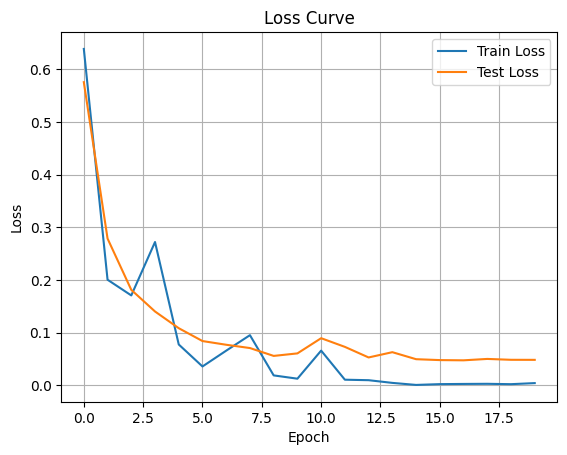

In [17]:
# Loss Curve
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

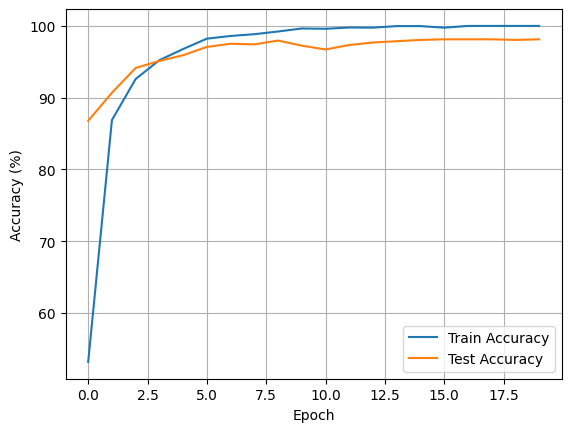

In [18]:
# Train vs Test Accuracy
train_acc = [t for t in train_correct]
test_acc = [t for t in test_correct]

plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

Predicted: desert
Actual: desert


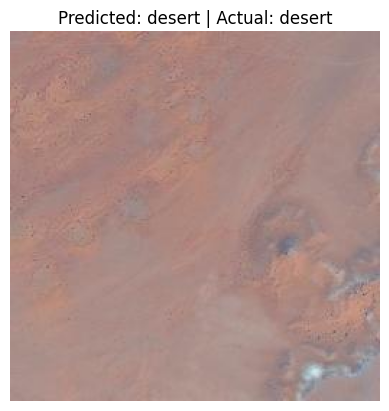

In [34]:
# Predict random image

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNetwork(num_classes=len(label_to_class))  # adjust if needed

model.load_state_dict(
    torch.load("model/final_satellite_cnn_5channel.pth", map_location=device)
)
model = model.to(device)
model.eval()

# Pick random image
random_index = random.randint(0, len(image_paths) - 1)
random_image_path = image_paths[random_index]
true_label = labels[random_index]

# Load image
img = Image.open(random_image_path).convert("RGB")
img_np = np.array(img)

# Compute 5 channels
r = img_np[:, :, 0]
g = img_np[:, :, 1]
b = img_np[:, :, 2]
rg = r - g
gb = g - b

# Stack into (H, W, 5)
img_5ch = np.stack([r, g, b, rg, gb], axis=2)

# Convert to tensor → (1, 5, H, W)
tensor_img = (
    torch.tensor(img_5ch, dtype=torch.float32)
    .permute(2, 0, 1)
    .unsqueeze(0)
    / 255.0
)

# Resize
tensor_img = F.interpolate(
    tensor_img,
    size=(224, 224),
    mode="bilinear",
    align_corners=False
)

# Normalize (MATCH TRAINING)
mean = tensor_img.mean(dim=(2, 3), keepdim=True)
std = tensor_img.std(dim=(2, 3), keepdim=True) + 1e-7
tensor_img = (tensor_img - mean) / std

# Move to device
tensor_img = tensor_img.to(device)
with torch.no_grad():
    outputs = model(tensor_img)
    predicted_class = torch.argmax(outputs, dim=1).item()
print("Predicted:", label_to_class[predicted_class])
print("Actual:", label_to_class[true_label])

plt.imshow(img)
plt.title(
    f"Predicted: {label_to_class[predicted_class]} | "
    f"Actual: {label_to_class[true_label]}"
)
plt.axis("off")
plt.show()


In [26]:
# Evaluate

# Load weights
model.load_state_dict(
    torch.load("model/final_satellite_cnn_5channel.pth", map_location=device)
)
# Move model to device
model = model.to(device)

model.eval()
test_correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_val = model(X_batch)
        predicted = torch.max(y_val, 1)[1]
        test_correct += (predicted == y_batch).sum().item()

print(f"Final Test Accuracy: {test_correct / len(test_loader.dataset) * 100 :.2f}%")

Final Test Accuracy: 98.14%
